# Introduction to Data Science
## From correlation to supervised segmentation and tree-structured models

Spring 2018 - Profs. Foster Provost and Josh Attenberg

Teaching Assistant: Apostolos Filippas


***

### Some general imports

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

Recall the automobile MPG dataset from last week? Because its familiar, let's reuse it here.

In [3]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                'model', 'origin', 'car_name']

mpg_df = pd.read_csv(url,
                     delim_whitespace=True,
                     header=None,
                     names=column_names).dropna()

Rather than attempt to predict the MPG from the other aspects of a car, let's try a simple classification problem, whether a car gets good milage (high MPG) or not

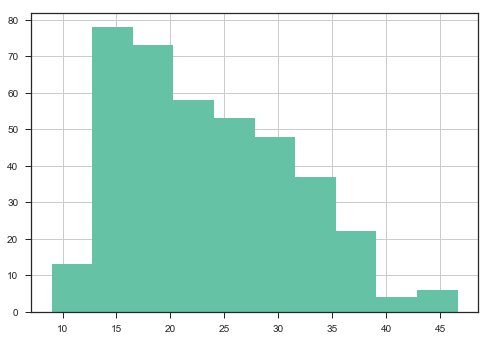

In [4]:
mpg_df["mpg"].hist()

Arbitrarily, let's say that those cars with a MPG greater than the median get good miles per gallon. 

In [5]:
median_mpg = mpg_df["mpg"].median()
print ("the median MPG is: %s" % median_mpg)

def is_high_mpg(mpg):
    return 1 if mpg > median_mpg else 0

mpg_df["is_high_mpg"] = mpg_df["mpg"].apply(is_high_mpg)

the median MPG is: 22.75


We'd like to use information contained in the other automobile quantities to predict whether or not the car is efficient. Let's take a look at how well these observables "split" our data according to our target.

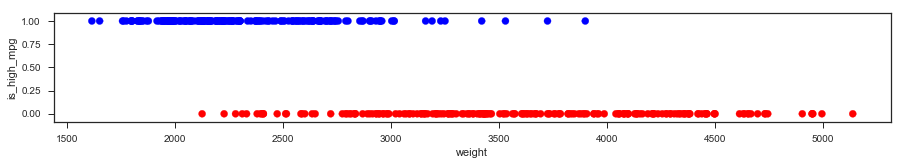

In [7]:
def visualize_split(df, target_column, info_column, color_one="red", color_two="blue"):
    plt.rcParams['figure.figsize'] = [15.0, 2.0]
    color = ["red" if x == 0 else "blue" for x in df[target_column]]
    plt.scatter(df[info_column], df[target_column], c=color, s=50)
    plt.xlabel(info_column)
    plt.ylabel(target_column)
    plt.show()
    
visualize_split(mpg_df, "is_high_mpg", "weight")

Above we see a scatter plot of all possible car weights and a color code that represents our target variable (is good mpg).
- Blue dots correspond to fuel efficient cars, red dots are fuel inefficient cars
- The horizontal position is the weight of the car
- The vertical position separates our two classes

Clearly car weight and high MPG-ness are correlated.

Looks like cars weighing more than 3000 lbs tend to be inefficient. How effective is this decision boundary? Let's quantify it!

***


**Entropy** ($H$) and **information gain** ($IG$) au useful tools for measuring the effectiveness of a split on the data. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="images/dsfb_0304.png" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="images/dsfb_0305.png" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

Given the data, it is fairly straight forward to calculate both of these quantities.

##### Functions to get the entropy and IG

In [8]:

def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()
    
    # compute probas
    probas = target_counts/total
    
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    
    tot = float(df.shape[0])
    
    
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 

Now that we have a way of calculating $H$ and $IG$, let's test our prior hunch, that using 3000 as a split on weight allows us to determine if a car is high MPG using $IG$.

In [9]:

threshold = 3000
prior_entropy = entropy(mpg_df["is_high_mpg"])
IG = information_gain(mpg_df, "weight", "is_high_mpg", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))


IG of 0.4632 using a threshold of 3000.00 given a prior entropy of 1.0000


How good was our guess of 3000? Let's loop through all possible splits on weight and see what is the best!

In [10]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

maximum_threshold, maximum_ig = best_threshold(mpg_df, "weight", "is_high_mpg")

print ("the maximum IG we can achieve splitting on weight is %.4f using a thresh of %.2f" % (maximum_ig, maximum_threshold))

the maximum IG we can achieve splitting on weight is 0.5017 using a thresh of 2755.00


Other observed features may also give us a strong clue about the efficiency of cars.

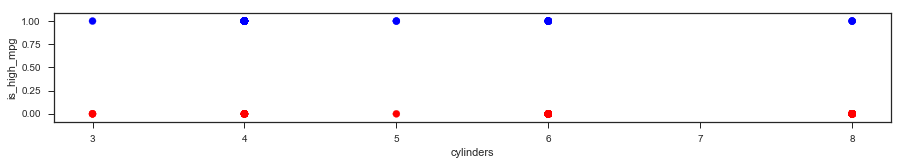

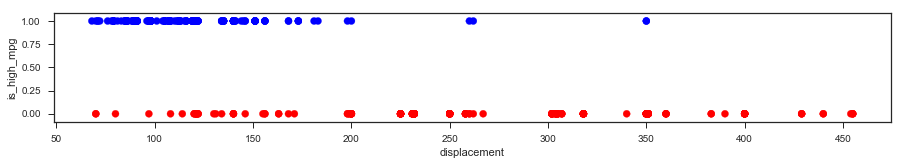

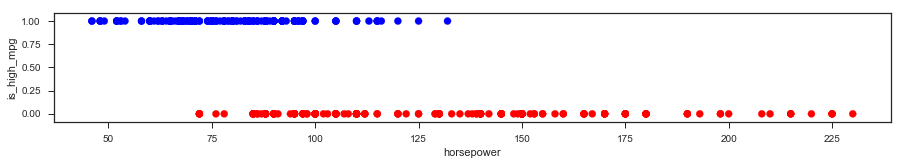

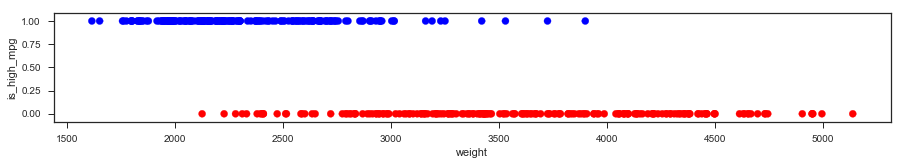

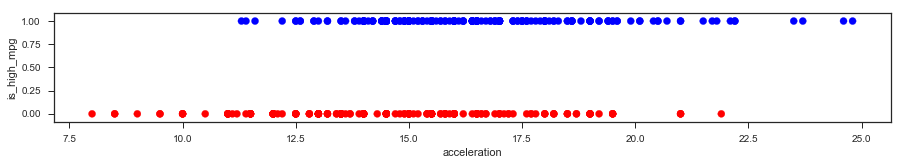

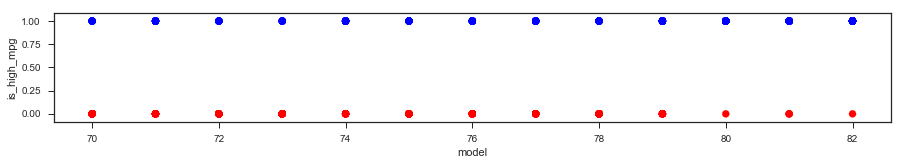

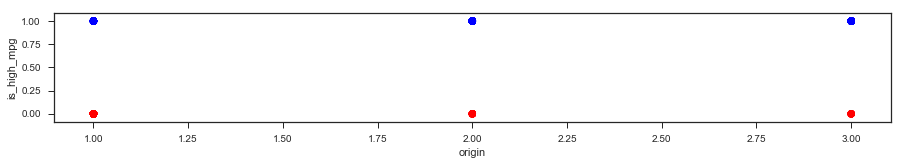

In [11]:
predictor_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model', 'origin']

for col in predictor_cols:
    visualize_split(mpg_df, "is_high_mpg", col)

This now begs the question: what feature gives the most effective split? 

In [12]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""
    
    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)
        
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

maximum_column, maximum_threshold, maximum_ig = best_split(mpg_df, predictor_cols, "is_high_mpg")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (maximum_column, maximum_ig, maximum_threshold))

the best column to split on is displacement giving us a IG of 0.5675 using a thresh of 183.00


### The Classifier Tree: Recursive Splitting

Of course, splitting the data one time sometimes isn't enough to make accurate categorical predictions. However, we can continue to split the data recursively until we achieve acceptable results. This recursive splitting is the basis for a "decision tree classifier" or "classifier tree", a popular and powerful class of machine learning algorithm. In particular, this specific algorithm is known as ID3 for Iterative Dichotomizer. 

What are some other ways you might consider splitting the data?

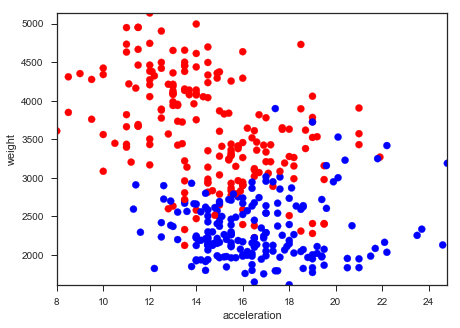

In [14]:
def Plot_Data(df, info_col_1, info_col_2, target_column, color1="red", color2="blue"):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = [color1 if x == 0 else color2 for x in df[target_column]]
    
    # Plot and label
    plt.scatter(df[info_col_1], df[info_col_2], c=color, s=50)
    plt.xlabel(info_col_1)
    plt.ylabel(info_col_2)
    plt.xlim([min(df[info_col_1]) , max(df[info_col_1]) ])
    plt.ylim([min(df[info_col_2]) , max(df[info_col_2]) ])
    plt.show()

plt.figure(figsize=[7,5])
Plot_Data(mpg_df, "acceleration",  "weight","is_high_mpg")

Rather than build a classifier tree from scratch (think if you could now do this!) let's use sklearn's implementation which includes some additional functionality. 

In [102]:
from sklearn.tree import DecisionTreeClassifier

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=1, criterion="entropy")   # Look at those 2 arguments !!! 

# Let's tell the model what is the data
decision_tree.fit(mpg_df[predictor_cols], mpg_df["is_high_mpg"])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We now have a classifier tree, let's visualize the results!

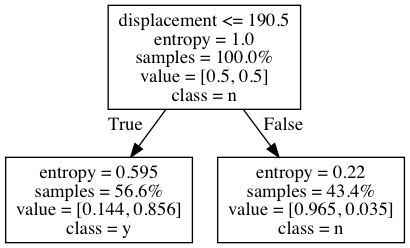

In [103]:
from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
        
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -Tpng %s -o %s" % (dot_name, image_name))
    # to get this part to actually work, you may need to open a terminal window in Jupyter and run the following command "sudo apt install graphviz"
    
    # Return the .png image so we can see it
    return Image(filename=image_name)

visualize_tree(decision_tree, predictor_cols, ["n", "y"])

Let's look at the `"acceleration"`,  `"weight"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html)

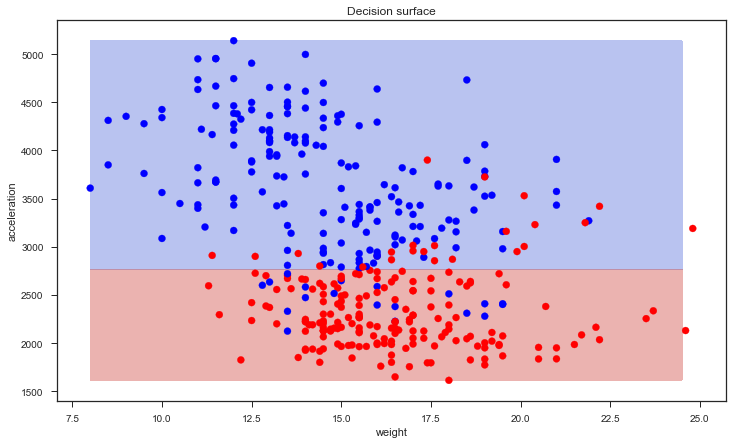

In [75]:
def Decision_Surface(data, col1, col2, target, model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max,0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    
    tdf = data[[col1, col2]]
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict(meshed_data).reshape(xx.shape)
    else:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
        
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.ylabel(col1)
    plt.xlabel(col2)
    
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1],cmap=plt.cm.coolwarm, alpha=0.4)
    
    color = ["blue" if t == 0 else "red" for t in target]
    plt.scatter(data[col1], data[col2], color=color )
    plt.show() 

tree_depth=1
Decision_Surface(mpg_df[predictor_cols], "acceleration", "weight", mpg_df["is_high_mpg"], DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy"), True)

How good is our model? Let's compute accuracy, the percent of times where we correctly identified that a car was high MPG.

In [76]:
from sklearn import metrics
print ( "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(mpg_df[predictor_cols]), mpg_df["is_high_mpg"])) )

Accuracy = 0.903


What are some other ways we could classify the data? Last class we used linear regression, let's take a look to see how that partitions the data

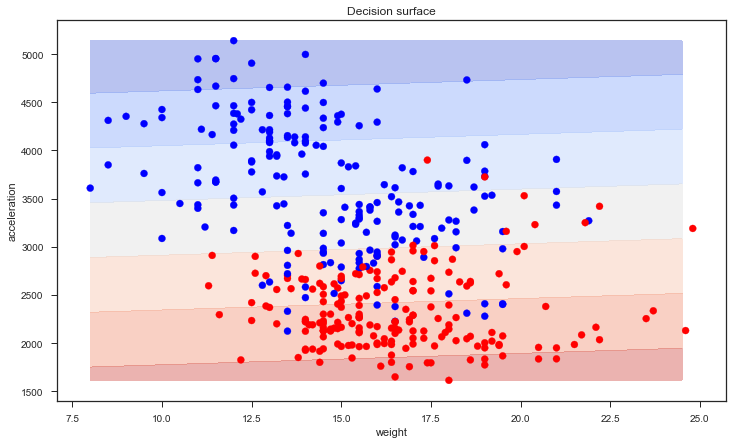

In [85]:
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

Decision_Surface(mpg_df[predictor_cols], "acceleration", "weight", mpg_df["is_high_mpg"], linear_model.Lasso(alpha=0.01), True)


## Decision Tree Regression

Recall our problem from last time, trying to predict the real-valued MPG for each car. In data science, problems where one tries to predict a real-valued number is known as regression. As with classification, much of the intuition for splitting data based on values of known observables applies:

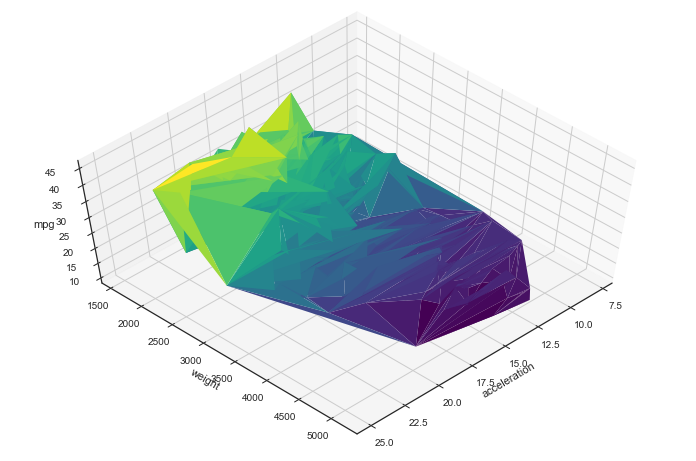

In [60]:
from mpl_toolkits.mplot3d import Axes3D
def plot_regression_data(df, info_col_1, info_col_2, target_column):

    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df[info_col_1], df[info_col_2], df[target_column], cmap=plt.cm.viridis, linewidth=0.2)
    ax.set_xlabel(info_col_1)
    ax.set_ylabel(info_col_2)
    ax.set_zlabel(target_column);
    ax.view_init(60, 45)

    plt.show()

plot_regression_data(mpg_df, "acceleration",  "weight", "mpg")

At a high level, one could imagine splitting the data recursively, assigning an estimated MPG to each side of the split. On more thoughtful reflection, some questions emerge:
- how do predict a real number at a leaf node given the examples that "filter" to that node?
- how do we assess the effectiveness of a particular split? 

As with decision tree classification, there are many valid answers to both of these questions. A typical approach involves collecting all nodes that filter to a leaf, computing the mean target value, and using this as a prediction. The effectiveness of a split can then be measured by computing the mean difference between all true values and this prediction.

As before, we can easily experiment with decison tree regression models using sklearn: 

In [100]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth=1, criterion="mse") # note the use of mse (mean squared error) as a criterion

regressor.fit(mpg_df[predictor_cols], mpg_df["mpg"])

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

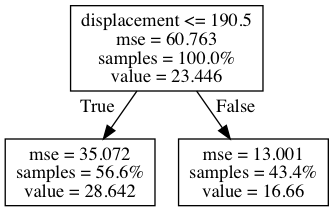

In [101]:
visualize_tree(regressor, predictor_cols, ["n", "y"])

As before, we can also view the "regression surface"

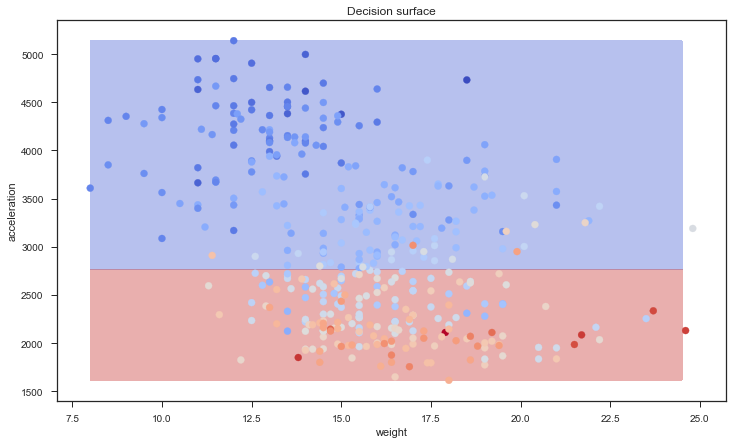

In [92]:
def Regression_Surface(data, col1, col2, target, model):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max,0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    
    tdf = data[[col1, col2]]
    model.fit(tdf, target)
    Z = model.predict(meshed_data).reshape(xx.shape)

        
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.ylabel(col1)
    plt.xlabel(col2)
    
    cs = plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)

    plt.scatter(data[col1], data[col2], c=target, cmap=plt.cm.coolwarm)
    plt.show() 

tree_depth=1
Regression_Surface(mpg_df[predictor_cols], "acceleration", "weight", mpg_df["mpg"], DecisionTreeRegressor(max_depth=tree_depth, criterion="mse"))

Let's also take a look using linear regression!

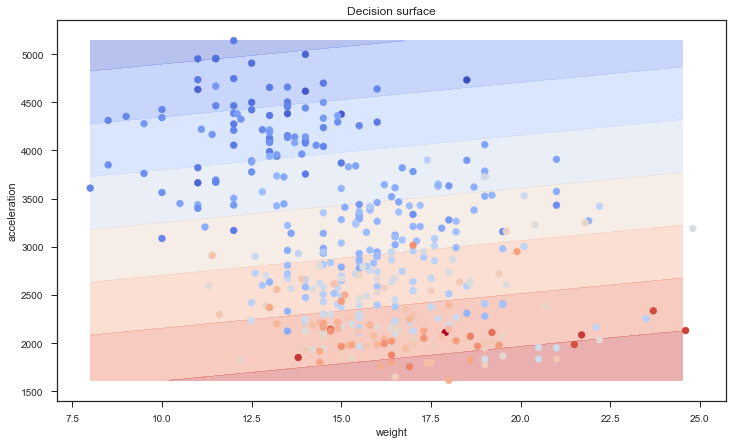

In [94]:
Regression_Surface(mpg_df[predictor_cols], "acceleration", "weight", mpg_df["mpg"], linear_model.LinearRegression())

How about a more complicated model? Let's try random forrest regression!

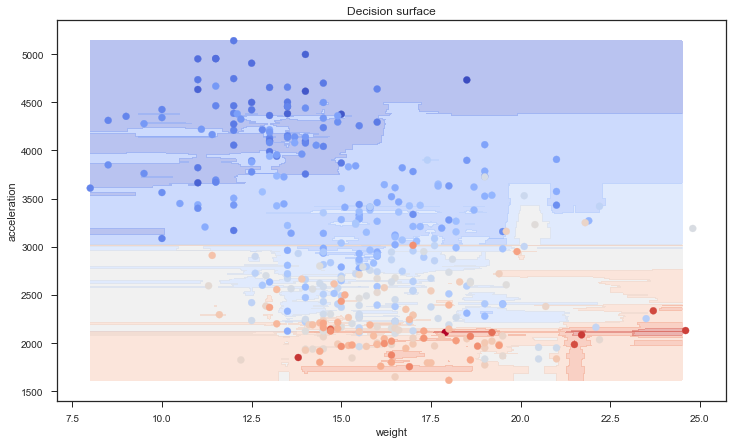

In [99]:
from sklearn.ensemble import RandomForestRegressor
Regression_Surface(mpg_df[predictor_cols], "acceleration", "weight", mpg_df["mpg"], RandomForestRegressor(n_estimators=10))